In [ ]:
import spacy
import pandas as pd
from collections import defaultdict, Counter
import en_core_web_lg

from geopy.geocoders import Nominatim
import folium
import time

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import re

import itertools

# Introduction

This notebook focuses on applying **Named Entity Recognition (NER)** to posts and comments collected from the selected subreddits: r/Israel, r/Jewish, r/Judaism, and r/ReformJews.

The primary goal of this step is to extract **named entities** (such as people, places, organizations, and events) to better understand **which entities dominate the discourse** in each subreddit and **how these entities are framed within the discussion**.

NER allows us to move beyond general topics and into **specific focal points** of the conversation, answering questions such as:
- Which political figures are most mentioned?
- What locations are central to the discussion?
- Are there specific religious institutions or cultural events that repeatedly appear?





In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
!pip install geopy folium

In [ ]:
!pip install ace_tools

In [ ]:
posts_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/posts_with_lda_topics.csv")
comments_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/comments_with_topics.csv")

/tmp/ipykernel_1122419/2785624615.py:2: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/comments_with_topics.csv")


In [ ]:
comments_topics['lda_topic'] = pd.to_numeric(
    comments_topics['lda_topic'],
    errors='coerce'
).fillna(-1).astype(int)

comments_topics = comments_topics[comments_topics['lda_topic'] != -1]

In [ ]:
import spacy
import pandas as pd
from collections import defaultdict, Counter
import en_core_web_lg

# Load a strong NLP model
nlp = en_core_web_lg.load()

# Define entity labels to extract
ENTITY_CATEGORIES = ["GPE", "PERSON", "ORG", "DATE", "EVENT"]

def extract_entities_by_topic(posts_df, comments_df):
    """
    Extracts named entities for each topic and entity type.
    """
    entity_data = defaultdict(lambda: defaultdict(Counter))  # topic -> entity_type -> {entity: count}

    topics = sorted(set(posts_df['lda_topic'].unique()).union(set(comments_df['lda_topic'].unique())))

    for topic in topics:
        print(f" Processing Topic {topic}...")

        # Collect all text for the given topic
        post_texts = " ".join(posts_df[posts_df['lda_topic'] == topic]['cleaned_text'].dropna())
        comment_texts = " ".join(comments_df[comments_df['lda_topic'] == topic]['cleaned_text'].dropna())
        combined_text = post_texts + " " + comment_texts

        # Split into chunks to prevent memory overload
        chunk_size = 1000
        text_chunks = [combined_text[i : i + chunk_size] for i in range(0, len(combined_text), chunk_size)]

        for chunk in text_chunks:
            doc = nlp(chunk)
            for ent in doc.ents:
                if ent.label_ in ENTITY_CATEGORIES:
                    entity_data[topic][ent.label_][ent.text] += 1  # Count occurrences of entity

    return entity_data

# Extract named entities
topic_entities = extract_entities_by_topic(posts_topics, comments_topics)

# Convert to DataFrame for easier handling
data_records = []
for topic, entity_types in topic_entities.items():
    for entity_type, entities in entity_types.items():
        for entity, count in entities.items():
            data_records.append({"Topic": topic, "Entity_Type": entity_type, "Entity": entity, "Count": count})

# Save results as a CSV file
df_entities = pd.DataFrame(data_records)
df_entities.to_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/NER/named_entities_by_topic.csv", index=False)

print("Named Entities extraction complete! Saved to CSV.")

In [ ]:
df_entities = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/NER/named_entities_by_topic.csv")

In [ ]:
df_entities

,Topic,Entity_Type,Entity,Count
0,-1,DATE,53578,1
1,0,ORG,houthi music video,1
2,0,ORG,idf,1197
3,0,ORG,idf national service,1
4,0,ORG,likud,376
...,...,...,...,...
282952,7,EVENT,passover seder temple,1
282953,7,EVENT,hebrew school jewish day,1
282954,7,EVENT,lodz 1938,1
282955,7,EVENT,shabbat practice,1


In [ ]:
# Load the NLP model
nlp = spacy.load("en_core_web_lg")

# Define entity labels to extract
ENTITY_CATEGORIES = ["GPE", "PERSON", "ORG", "DATE", "EVENT"]

def extract_named_entities(posts_df, comments_df, chunk_size=5000):
    """
    Extracts named entities for each topic while tracking post/comment ID.
    Processes data in chunks to prevent memory overload.

    Returns:
    - DataFrame containing extracted entities, their type, topic, ID, and source type.
    """

    print("Starting named entity extraction...")

    entity_records = []
    total_documents = len(posts_df) + len(comments_df)
    processed_docs = 0

    for df, source in [(posts_df, "post"), (comments_df, "comment")]:
        texts = df["cleaned_text"].dropna().tolist()
        ids = df["id"].tolist()
        topics = df["lda_topic"].tolist()

        print(f"Processing {len(texts)} {source}s...")

        # Process text in chunks
        for i in range(0, len(texts), chunk_size):
            text_chunk = texts[i : i + chunk_size]
            id_chunk = ids[i : i + chunk_size]
            topic_chunk = topics[i : i + chunk_size]

            # Process the chunk using spaCy
            docs = list(nlp.pipe(text_chunk, disable=["parser", "tagger"]))

            for doc, item_id, topic in zip(docs, id_chunk, topic_chunk):
                processed_docs += 1
                if processed_docs % 5000 == 0:
                    print(f"Processed {processed_docs}/{total_documents} documents...")

                for ent in doc.ents:
                    if ent.label_ in ENTITY_CATEGORIES:
                        entity_records.append({
                            "Topic": topic,
                            "Entity_Type": ent.label_,
                            "Entity": ent.text,
                            "Count": 1,
                            "Item_ID": item_id,
                            "Source": source
                        })

    print(f"Named entity extraction completed. Extracted {len(entity_records)} entity mentions.")
    return pd.DataFrame(entity_records)

In [ ]:
# Run entity extraction
df_entities_with_id = extract_named_entities(posts_topics, comments_topics, chunk_size=5000)

# Save results
df_entities_with_id.to_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/NER/named_entities_with_id.csv", index=False)

# Reload the dataset (please ensure the correct file path)
file_path = "/dt/yisroel/Users/luzone/BIG_DATA/models/NER/named_entities_with_id.csv"

# Load the extracted entity dataset
df_entities_with_id = pd.read_csv(file_path)

/tmp/ipykernel_1122419/1901970119.py:6: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_topics = pd.read_csv(comments_file_path)


In [ ]:
df_entities_with_id = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/NER/named_entities_with_id.csv")

In [ ]:
# Define function to format entity distribution table with summed occurrences
def format_entity_distribution_table_summed(df, entity_categories, top_n=5):
    """
    Formats the entity distribution table to present topics as rows and entity types as columns,
    showing the top entities per topic for each entity type, while summing occurrences of each entity.
    """
    # Filter out Topic -1
    df = df[df['Topic'] >= 0]

    # Aggregate counts per entity to avoid duplicate records
    df_summed = df.groupby(["Topic", "Entity_Type", "Entity"], as_index=False)["Count"].sum()

    # Initialize dictionary to store results
    table_data = []

    # Iterate over topics and entity types
    topics = sorted(df_summed['Topic'].unique())
    for topic in topics:
        row_data = {"Topic": f"Topic {topic}"}
        for entity_type in entity_categories:
            # Get top entities for this topic and type
            subset = df_summed[(df_summed['Topic'] == topic) & (df_summed['Entity_Type'] == entity_type)]
            top_entities = subset.nlargest(top_n, 'Count')[['Entity', 'Count']]

            # Format entity names with counts
            entity_list = [f"{row['Entity']} ({row['Count']})" for _, row in top_entities.iterrows()]

            # Store in row format
            row_data[entity_type] = ', '.join(entity_list)

        # Append row data to list
        table_data.append(row_data)

    # Convert to DataFrame
    table_df = pd.DataFrame(table_data)

    return table_df

# Example usage (assuming df_entities_with_id is loaded)
ENTITY_CATEGORIES = ["GPE", "PERSON", "ORG", "DATE", "EVENT"]



In [ ]:
formatted_table_summed = format_entity_distribution_table_summed(df_entities_with_id, ENTITY_CATEGORIES)
formatted_table_summed

,Topic,GPE,PERSON,ORG,DATE,EVENT
0,Topic 0,"israel (28194), iran (9112), gaza (5825), russia (2574), lebanon (2530)","biden (3475), netanyahu (2018), bibi (1543), ben gvir (597), putin (595)","hamas (11271), hezbollah (4644), idf (1215), mossad (433), nato (393)","today (468), october (441), oct (319), month (246), year (235)","lebanon war (46), olympics (38), yom kippur war (13), vietnam war (12), wwii (12)"
1,Topic 1,"israel (16023), tel aviv (2076), jerusalem (1751), gaza (1494), canada (819)","magen david (625), david (527), torah (247), david necklace (243), biden (242)","hamas (2178), idf (481), amazon (396), hezbollah (366), chabad (273)","today (1752), friday (1377), year (1366), year ago (1189), saturday (1136)","olympics (51), hanukkah (22), shabbat shalom (19), wwii (16), sukkot (13)"
2,Topic 2,"israel (2468), palestine (866), germany (399), gaza (312), america (198)","via modmail (182), modmail (179), hitler (174), biden (137), antizionism (111)","hamas (1081), adl (281), wikipedia (260), harvard (220), congress (204)","today (407), october (159), oct (107), yesterday (80), last year (76)","olympics (14), wwii (14), arabic slang war (3), auschwitz (3), jvp (3)"
3,Topic 3,"israel (15330), gaza (10159), palestine (833), iran (569), west bank (534)","netanyahu (283), bibi (145), biden (136), gazan (134), hamas (108)","hamas (26399), idf (1821), hezbollah (593), bbc (418), cnn (290)","october 7th (1605), october (1358), oct (854), oct 7th (673), today (648)","geneva convention (22), wwii (22), olympics (18), hebrew university (10), lebanon war (8)"
4,Topic 4,"israel (85149), palestine (11271), gaza (10065), west bank (5994), egypt (5128)","netanyahu (966), jordan (734), biden (585), arafat (574), bibi (541)","hamas (13261), hezbollah (972), plo (808), islam (649), idf (500)","today (3655), 1948 (2878), 1967 (949), year (820), october (747)","wwii (148), geneva convention (53), olympics (46), yom kippur war (16), eurovision song (14)"
5,Topic 5,"israel (2275), jerusalem (484), egypt (325), gaza (149), palestine (109)","torah (841), asher (333), god (324), moses (291), hashem (193)","hamas (349), youtube (212), ord (179), talmud (126), rashi (91)","today (758), yom kippur (419), weekly (297), daily (258), christmas (192)","sukkot (14), hanukkah (11), olympics (11), yom kippur (10), yom kippur war (8)"
6,Topic 6,"israel (137661), gaza (18375), palestine (12835), iran (8421), america (5769)","biden (5069), netanyahu (3965), bibi (3732), jesus (1777), hitler (1211)","hamas (48694), hezbollah (3920), idf (2502), instagram (1417), likud (712)","today (7692), october 7th (4920), october (3904), oct (3254), year (2442)","olympics (287), wwii (260), vietnam war (52), hanukkah (35), post october 7th (29)"
7,Topic 7,"israel (12547), poland (1280), germany (1077), america (1062), spain (814)","jesus (3500), torah (1937), kabbalah (889), islam (683), abraham (521)","hamas (556), islam (487), nonorthodox (387), sephardi (303), chabad (257)","today (2523), year (797), year ago (735), last year (480), christmas (439)","wwii (81), hanukkah (21), jewish day (13), jewish quarter (13), olympics (9)"


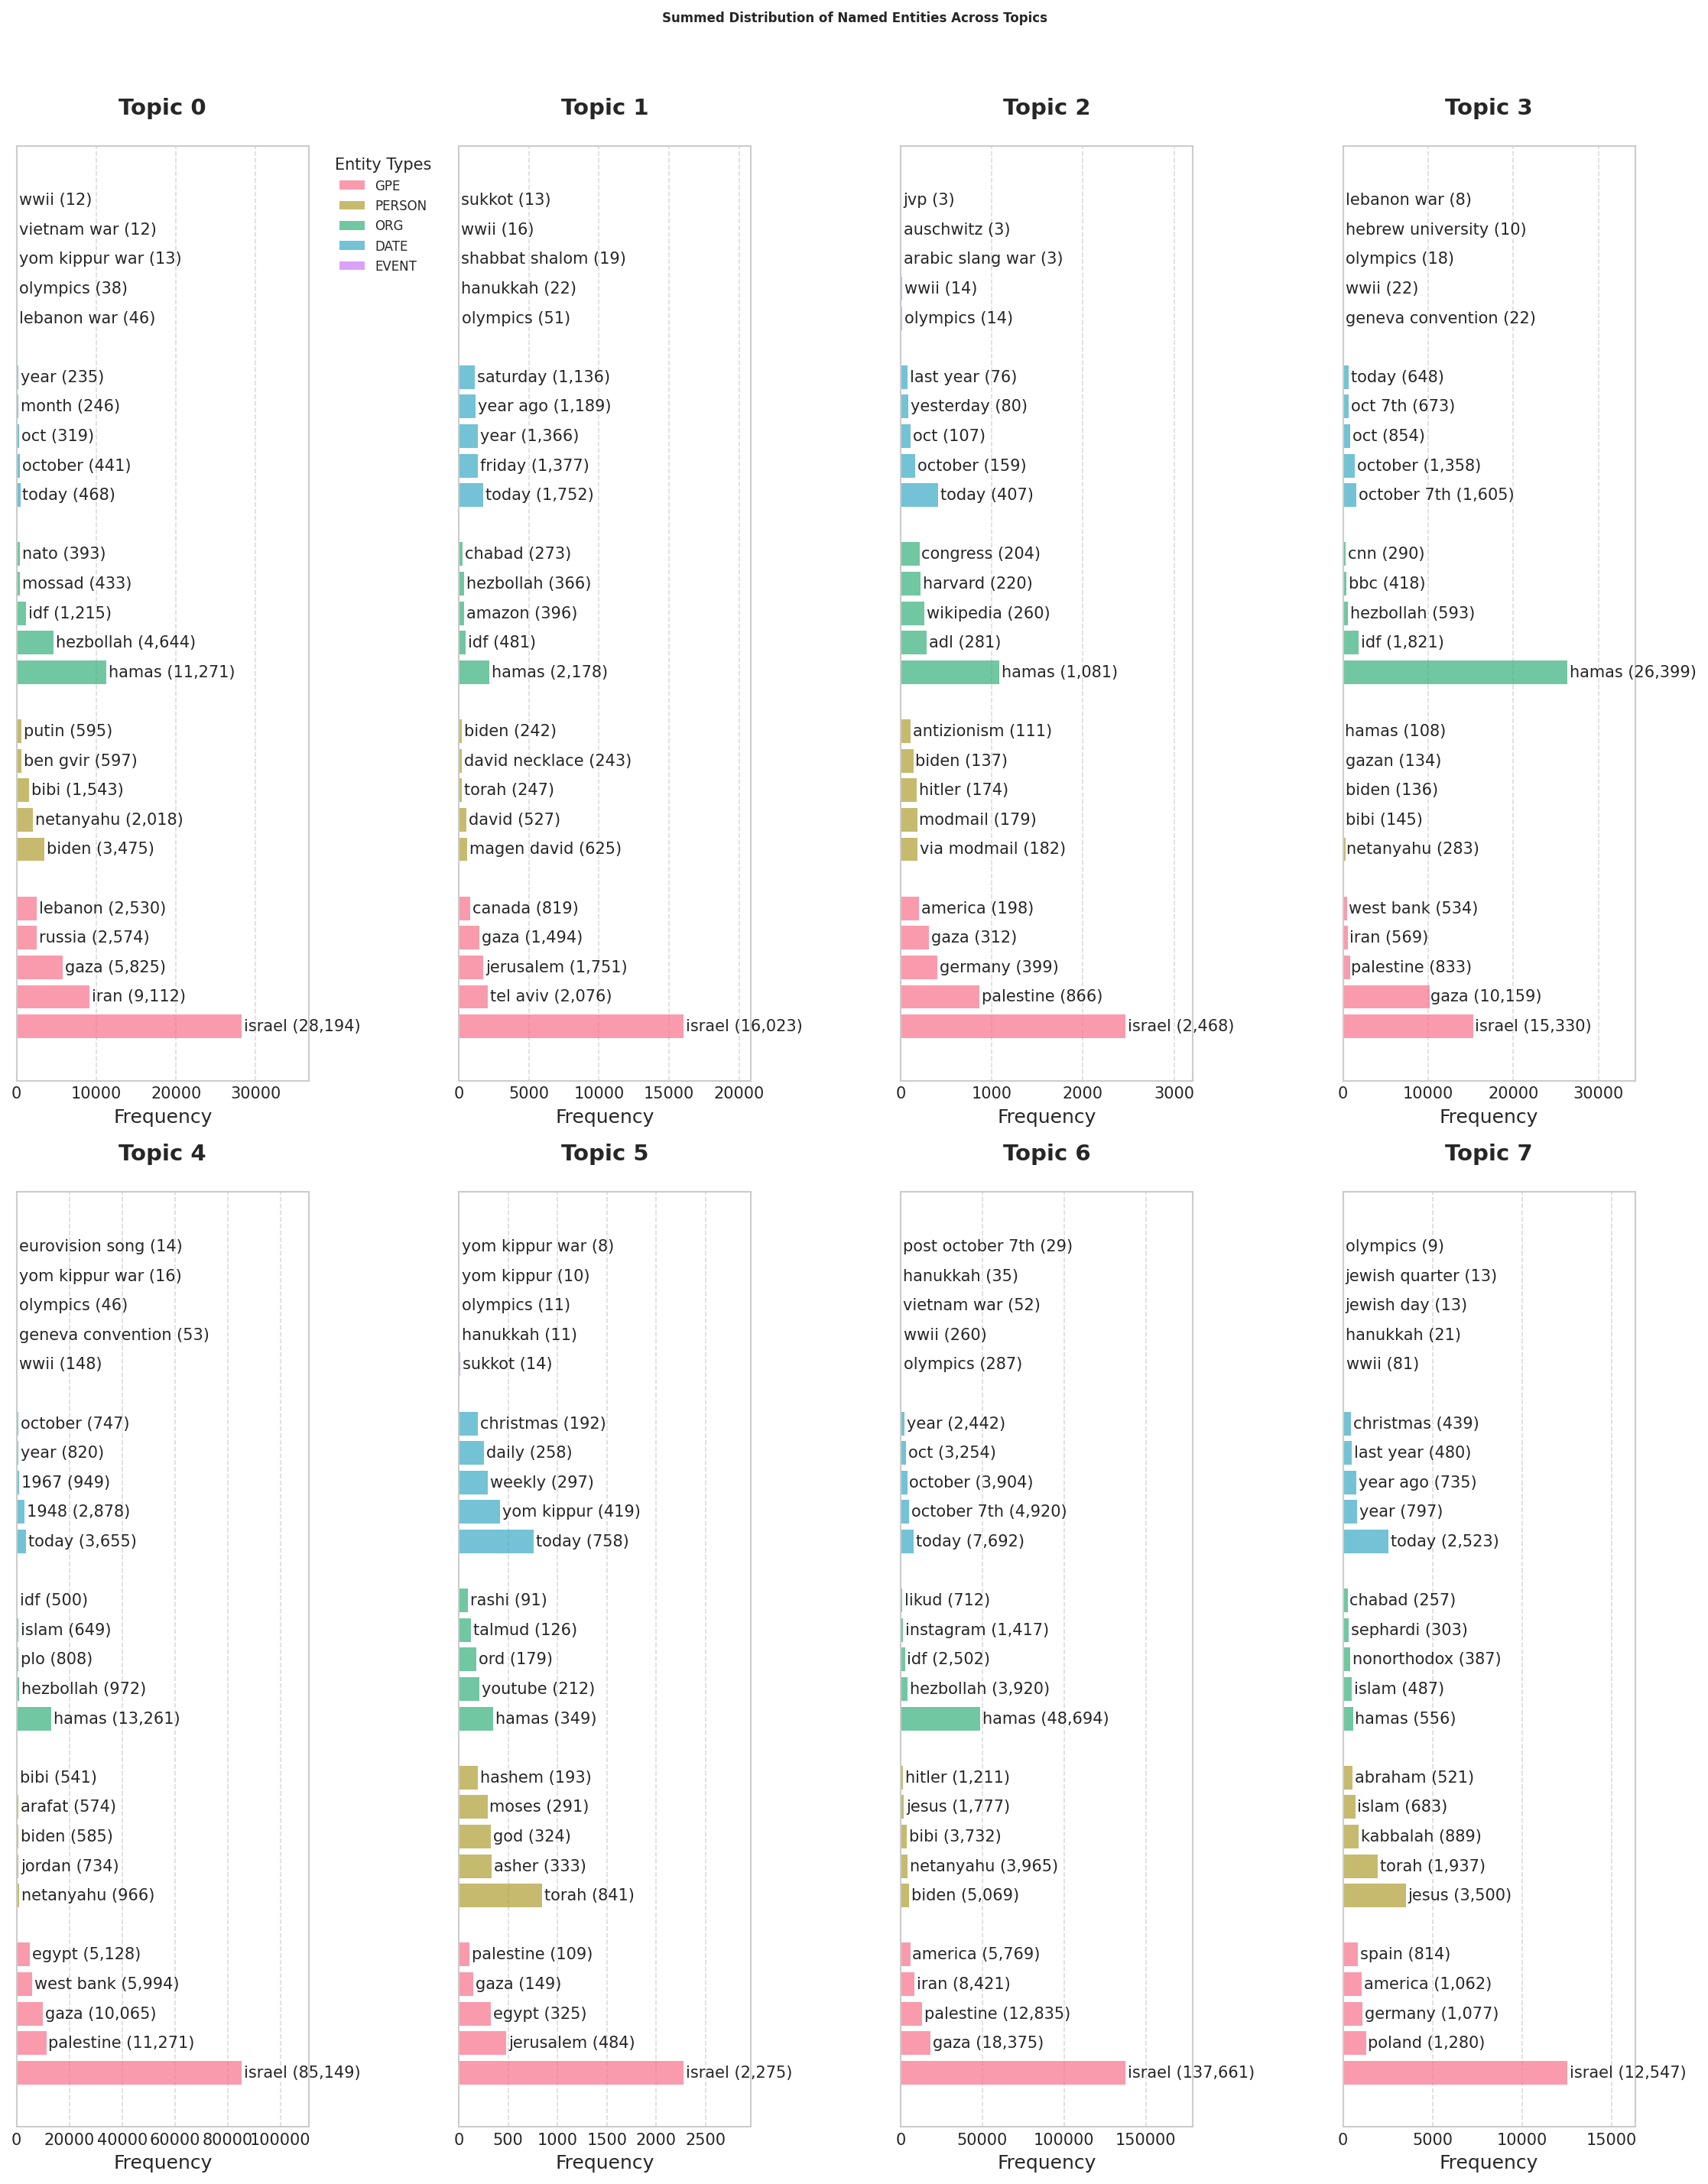

In [ ]:
def create_entity_distribution_plot_summed(df, entity_categories, top_n=5):
    """
    Creates a publication-quality visualization of entity distributions across topics,
    summing occurrences of each entity.
    """
    # Filter out Topic -1 and sort topics
    df = df[df['Topic'] >= 0]

    # Aggregate counts per entity to avoid duplicate records
    df_summed = df.groupby(["Topic", "Entity_Type", "Entity"], as_index=False)["Count"].sum()

    # Extract unique topics
    topics = sorted(df_summed['Topic'].unique())

    # Set the style for publication-quality output
    plt.style.use('seaborn-v0_8-whitegrid')

    # Calculate number of rows and columns for the grid
    n_topics = len(topics)
    n_cols = min(n_topics, 4)  # Dynamically adjust columns
    n_rows = (n_topics + n_cols - 1) // n_cols  # Calculate rows needed

    # Create the figure with appropriate size and higher DPI
    fig = plt.figure(figsize=(15, 10 * n_rows), dpi=150)

    # Create color palette for entity types
    colors = sns.color_palette("husl", len(entity_categories))
    entity_colors = dict(zip(entity_categories, colors))

    # Create subplots for each topic
    for topic_idx, topic in enumerate(topics):
        ax = plt.subplot(n_rows, n_cols, topic_idx + 1)

        # Create a list to store the bars for the legend
        legend_handles = []

        # Plot each entity type
        y_offset = 0
        max_count = 0  # Track maximum count for x-axis scaling

        for entity_type in entity_categories:
            # Get top entities for this topic and type
            subset = df_summed[(df_summed['Topic'] == topic) & (df_summed['Entity_Type'] == entity_type)]
            top_entities = subset.nlargest(top_n, 'Count')

            if not top_entities.empty:
                # Update max count
                max_count = max(max_count, top_entities['Count'].max())

                # Calculate y positions
                positions = [i + y_offset for i in range(len(top_entities))]

                # Plot horizontal bars
                bars = ax.barh(y=positions,
                               width=top_entities['Count'],
                               label=entity_type,
                               color=entity_colors[entity_type],
                               alpha=0.7,
                               height=0.8)

                # Add entity labels
                for idx, row in enumerate(top_entities.itertuples()):
                    label_text = f"{row.Entity} ({row.Count:,})"
                    ax.text(row.Count + (max_count * 0.01),  # Add small padding
                            positions[idx],
                            label_text,
                            va='center',
                            ha='left',
                            fontsize=10)

                y_offset += len(top_entities) + 1
                legend_handles.append(bars)

        # Customize the subplot
        ax.set_title(f'Topic {topic}', pad=20, fontsize=14, fontweight='bold')
        ax.set_xlabel('Frequency', fontsize=12)
        ax.set_yticks([])

        # Set x-axis limit with some padding
        ax.set_xlim(0, max_count * 1.3)

        # Add gridlines for better readability
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)

        # Add legend only to the first subplot
        if topic_idx == 0:
            ax.legend(title='Entity Types',
                      bbox_to_anchor=(1.05, 1),
                      loc='upper left',
                      fontsize=8)

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Add overall title
    fig.suptitle('Summed Distribution of Named Entities Across Topics',
                 fontsize=8,
                 fontweight='bold',
                 y=0.98)

    return fig


ENTITY_CATEGORIES = ["GPE", "PERSON", "ORG", "DATE", "EVENT"]

# Generate the visualization
fig_summed = create_entity_distribution_plot_summed(df_entities_with_id, ENTITY_CATEGORIES)

# Display the plot
plt.show()

In [ ]:
geolocator = Nominatim(user_agent="reddit_topics_app")

df_gpe = df_entities[df_entities["Entity_Type"]=="GPE"].copy()

In [ ]:
def get_coordinates_by_topic(place):
    """Get (lat, lon) using geopy. returns (None,None) if not found."""
    try:
        loc = geolocator.geocode(place)
        if loc:
            return (loc.latitude, loc.longitude)
    except:
        pass
    return (None, None)

# Initialize geolocator
geolocator = Nominatim(user_agent="reddit_topics_app")

# Filter only GPE entities
df_gpe = df_entities[df_entities["Entity_Type"]=="GPE"].copy()

# Select top 30 GPE per topic
df_gpe = df_gpe.groupby("Topic").apply(lambda x: x.nlargest(20, "Count")).reset_index(drop=True)

# Generate unique colors per topic
topics = sorted(df_gpe["Topic"].unique())
colors = sns.color_palette("husl", len(topics)).as_hex()
colors_map = dict(zip(topics, colors))

# Caching coordinates to optimize API calls
coords_map = {}
for gpe in df_gpe["Entity"].unique():
    coords_map[gpe] = get_coordinates_by_topic(gpe)
    time.sleep(1)  # To avoid hitting the rate limit

df_gpe["coords"] = df_gpe["Entity"].map(coords_map)
df_gpe["lat"] = df_gpe["coords"].apply(lambda x: x[0] if x else None)
df_gpe["lon"] = df_gpe["coords"].apply(lambda x: x[1] if x else None)

# Filter only entities with coordinates
df_gpe = df_gpe.dropna(subset=["lat","lon"])

# Create map
m = folium.Map(location=[31.0, 35.0], zoom_start=2)

for idx, row in df_gpe.iterrows():
    count = row["Count"]
    place = row["Entity"]
    topic = row["Topic"]
    color = colors_map.get(topic, 'blue')  # Assign color by topic
    popup_text = f"{place} (Count={count}, Topic={topic})"
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3 + count**0.5,
        color=color,
        fill=True,
        fill_color=color,
        tooltip=popup_text
    ).add_to(m)

m.save("all_topics_map.html")
m

/tmp/ipykernel_356476/3860412444.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gpe = df_gpe.groupby("Topic").apply(lambda x: x.nlargest(20, "Count")).reset_index(drop=True)


In [ ]:
def get_coordinates(place):
    """Get (lat, lon) using geopy. returns (None,None) if not found."""
    try:
        loc = geolocator.geocode(place)
        if loc:
            return (loc.latitude, loc.longitude)
    except:
        pass
    return (None, None)

# Initialize geolocator
geolocator = Nominatim(user_agent="reddit_topics_app")

# Filter only GPE entities
df_gpe = df_entities[df_entities["Entity_Type"]=="GPE"].copy()

# Select top 20 GPE per topic
df_gpe = df_gpe.groupby("Topic").apply(lambda x: x.nlargest(20, "Count")).reset_index(drop=True)

# Aggregate data to ensure unique locations with summed counts
df_gpe = df_gpe.groupby("Entity").agg({"Count": "sum"}).reset_index()

# Caching coordinates to optimize API calls
coords_map = {}
for gpe in df_gpe["Entity"].unique():
    coords_map[gpe] = get_coordinates(gpe)
    time.sleep(1)

df_gpe["coords"] = df_gpe["Entity"].map(coords_map)
df_gpe["lat"] = df_gpe["coords"].apply(lambda x: x[0] if x else None)
df_gpe["lon"] = df_gpe["coords"].apply(lambda x: x[1] if x else None)

# Filter only entities with coordinates
df_gpe = df_gpe.dropna(subset=["lat","lon"])

# Normalize circle size to prevent oversized markers
max_count = df_gpe["Count"].max()

def scale_radius(count, max_count, min_size=4, max_size=20):
    return min_size + (count / max_count) * (max_size - min_size)

# Create map
m = folium.Map(location=[31.0, 35.0], zoom_start=2)

for idx, row in df_gpe.iterrows():
    count = row["Count"]
    place = row["Entity"]
    radius = scale_radius(count, max_count)
    popup_text = f"{place} (Count={count})"
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color='red',  # Single color for all locations
        fill=True,
        fill_color='red',
        tooltip=popup_text
    ).add_to(m)

m.save("scaled_unique_locations_map.html")
m

/tmp/ipykernel_356476/662960052.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gpe = df_gpe.groupby("Topic").apply(lambda x: x.nlargest(20, "Count")).reset_index(drop=True)


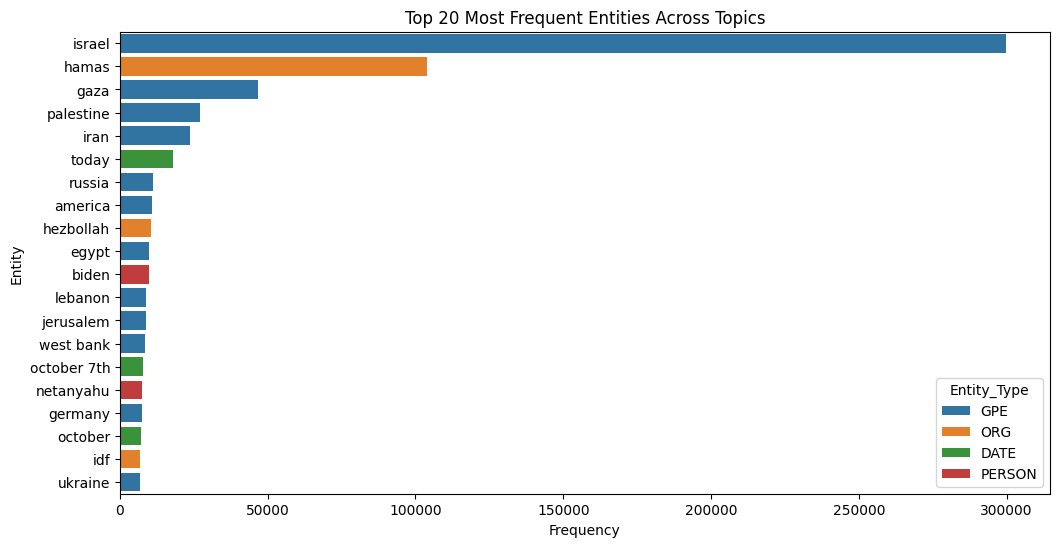

In [ ]:
# Identify the most frequently mentioned entities across all topics
top_entities = df_entities_with_id.groupby(["Entity_Type", "Entity"])["Count"].sum().reset_index()
top_entities = top_entities.sort_values(by="Count", ascending=False)

# Display the most frequently mentioned entities per entity type
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the top entities
plt.figure(figsize=(12, 6))
sns.barplot(data=top_entities.head(20), x="Count", y="Entity", hue="Entity_Type", dodge=False)
plt.xlabel("Frequency")
plt.ylabel("Entity")
plt.title("Top 20 Most Frequent Entities Across Topics")
plt.show()

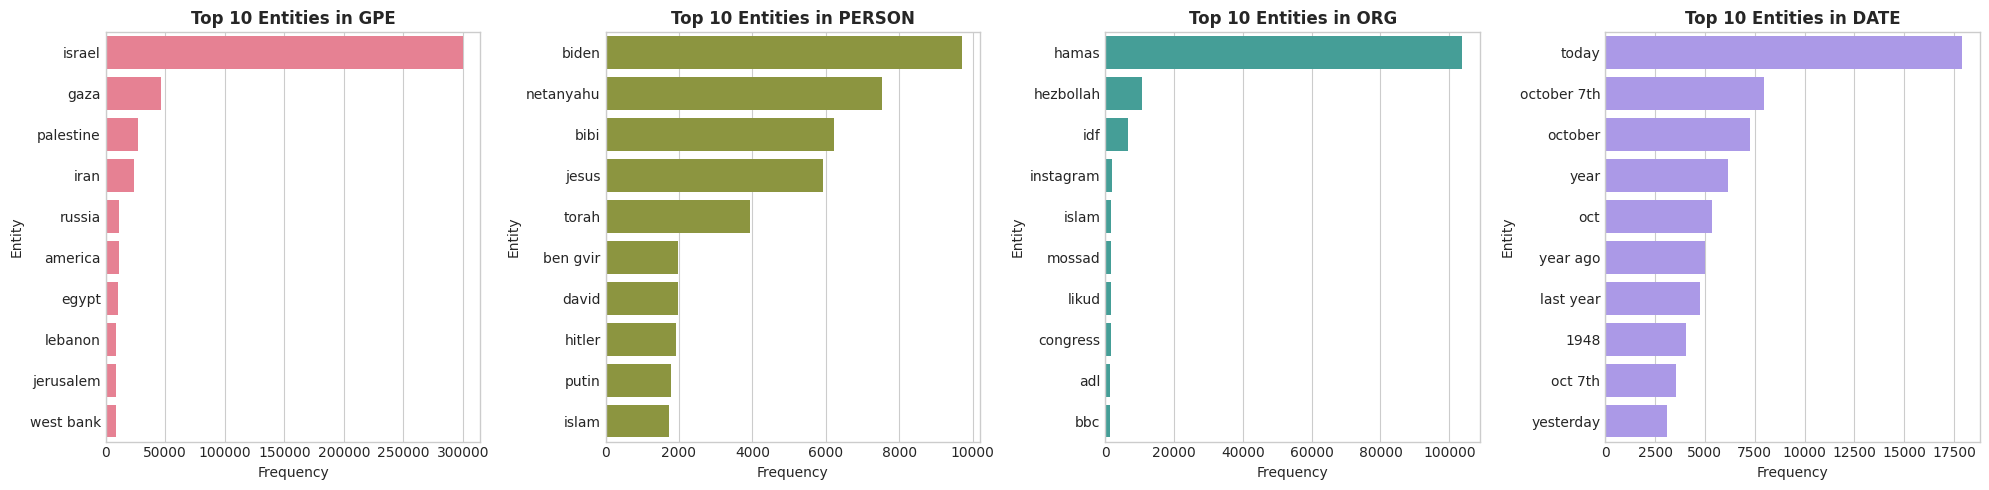

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_entities_by_category(df, entity_categories, top_n=10):
    """
    Plots top entities for each category in a row, ensuring:
    - Labels are on the left.
    - Each category has a different color.
    - Graphs have the same size and scale.
    """
    num_categories = len(entity_categories)
    fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 5, 5), sharex=False)

    # Define a color palette for each entity category
    colors = sns.color_palette("husl", num_categories)
    entity_colors = dict(zip(entity_categories, colors))

    for idx, entity_type in enumerate(entity_categories):
        ax = axes[idx]

        # Filter top entities for this category
        subset = df[df["Entity_Type"] == entity_type]
        top_entities = subset.groupby("Entity")["Count"].sum().nlargest(top_n).reset_index()

        # Create the barplot
        sns.barplot(data=top_entities, x="Count", y="Entity", ax=ax, color=entity_colors[entity_type])

        # Set title and labels
        ax.set_title(f"Top {top_n} Entities in {entity_type}", fontsize=12, fontweight="bold")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Entity")

        # Ensure entity labels appear on the left
        ax.yaxis.set_label_position("left")
        ax.yaxis.tick_left()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Define categories and call the function
ENTITY_CATEGORIES = ["GPE", "PERSON", "ORG", "DATE"]
plot_top_entities_by_category(df_entities_with_id, ENTITY_CATEGORIES, top_n=10)


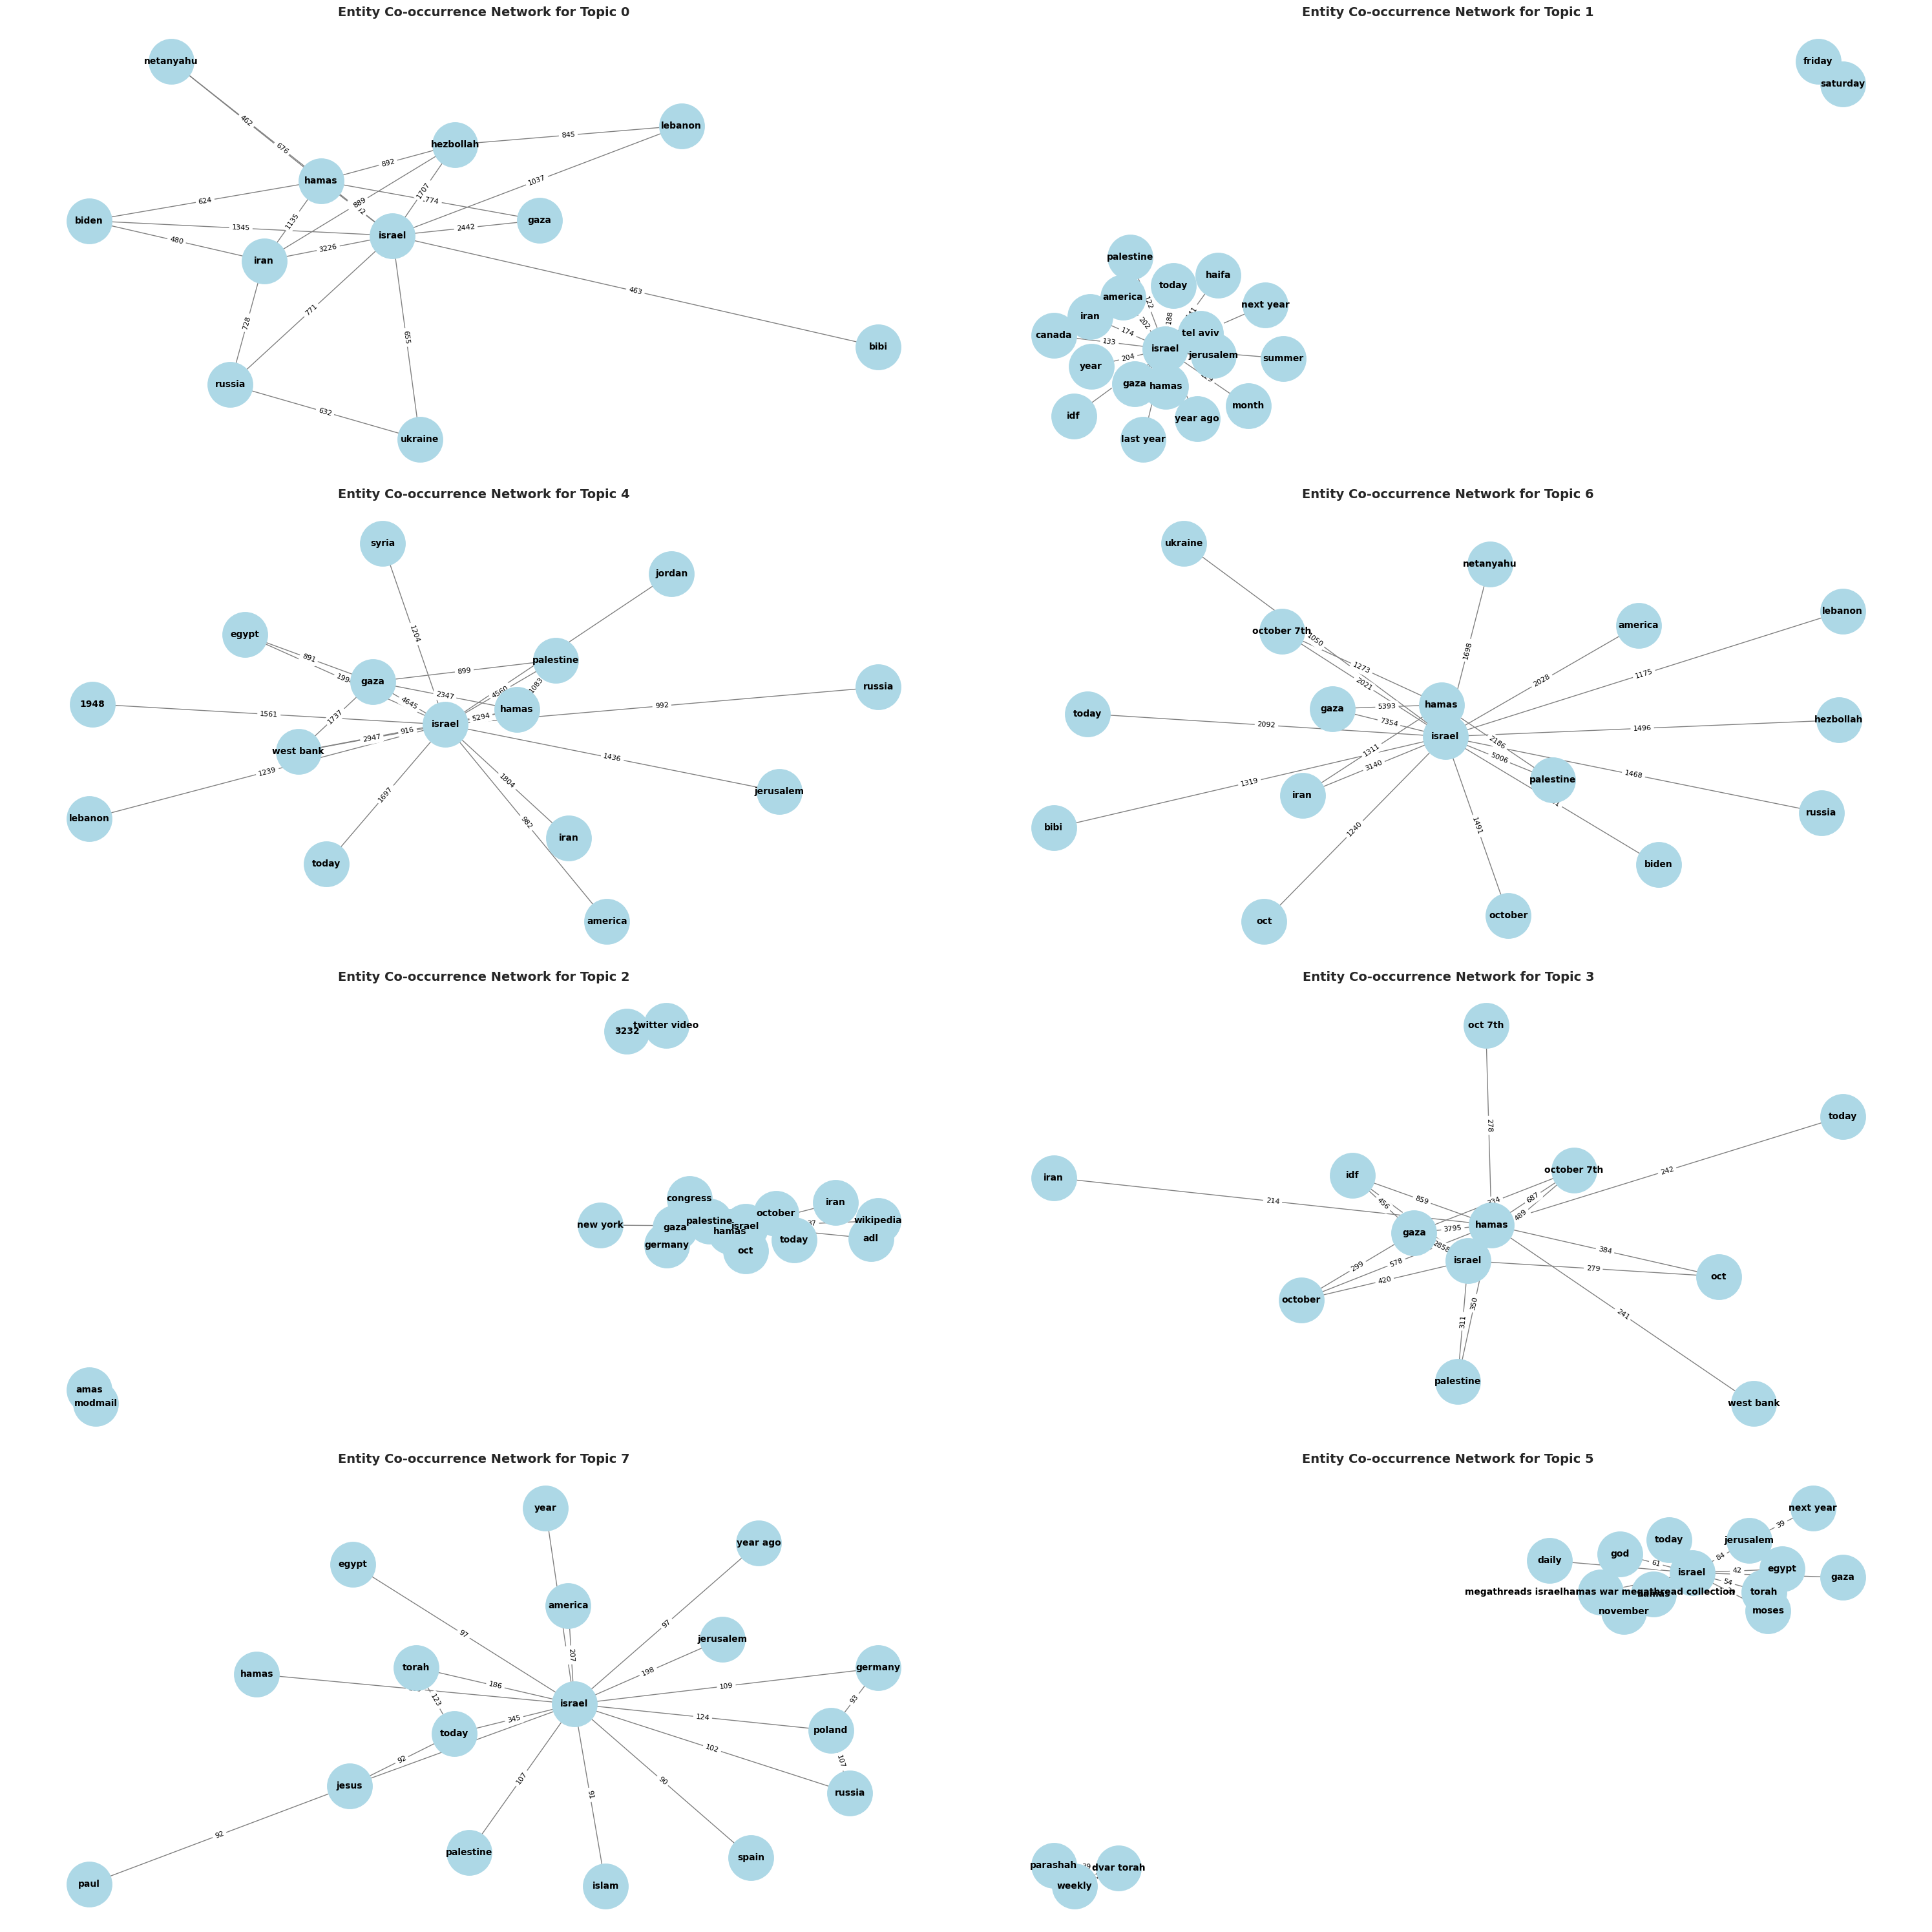

In [ ]:
def compute_entity_cooccurrence_by_topic(df, topic):
    """
    Computes entity co-occurrences within a specific topic.

    Parameters:
    - df (DataFrame): The dataset containing 'Item_ID', 'Topic', and 'Entity'.
    - topic (int): The topic for which to compute entity co-occurrence.

    Returns:
    - DataFrame containing entity pairs and their co-occurrence counts.
    """
    # Filter the data for the specific topic
    df_topic = df[df["Topic"] == topic]

    # Group entities by each post/comment
    grouped_entities = df_topic.groupby("Item_ID")["Entity"].apply(list)

    # Count pairs of entities that appear together
    cooccurrence_counter = Counter()
    for entity_list in grouped_entities:
        # Keep only string entities
        entity_list = [entity for entity in entity_list if isinstance(entity, str)]
        # Create unique sorted pairs
        entity_pairs = itertools.combinations(sorted(set(entity_list)), 2)
        cooccurrence_counter.update(entity_pairs)

    # Convert the counts to a DataFrame
    cooccurrence_df = pd.DataFrame(cooccurrence_counter.items(), columns=["Entity_Pair", "Count"])
    cooccurrence_df[["Entity1", "Entity2"]] = pd.DataFrame(
        cooccurrence_df["Entity_Pair"].tolist(),
        index=cooccurrence_df.index
    )
    cooccurrence_df.drop(columns=["Entity_Pair"], inplace=True)
    cooccurrence_df = cooccurrence_df.sort_values(by="Count", ascending=False)

    return cooccurrence_df

def visualize_entity_cooccurrence(df, topic, top_n=20):
    """
    Creates a network graph of entity co-occurrences for a specific topic.

    Parameters:
    - df (DataFrame): The dataset containing entity co-occurrence data.
    - topic (int): The topic to visualize.
    - top_n (int): Number of top entity pairs to visualize.

    This function draws the network graph but does not call plt.show()
    (so it can be used inside subplots).
    """
    G = nx.Graph()

    # Keep only the strongest connections
    df_top = df.head(top_n)

    # Add edges to the graph
    for _, row in df_top.iterrows():
        G.add_edge(row["Entity1"], row["Entity2"], weight=row["Count"])

    # Draw the graph
    pos = nx.spring_layout(G, k=0.5, seed=42)
    edges = G.edges(data=True)

    nx.draw(
        G, pos, with_labels=True, node_color="lightblue", edge_color="gray",
        node_size=2500, font_size=10, font_weight="bold"
    )

    # Add edge labels for co-occurrence counts
    edge_labels = {(u, v): d["weight"] for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Entity Co-occurrence Network for Topic {topic}", fontsize=14, fontweight="bold")

def plot_multiple_topics(df, topics, top_n=20):
    """
    Plots the entity co-occurrence network graphs for multiple topics in a 2-row, 4-column layout.

    Parameters:
    - df (DataFrame): The dataset containing entity co-occurrence data.
    - topics (list): The list of topics to visualize.
    - top_n (int): Number of top entity pairs to visualize per topic.

    This function displays up to 8 topics (4 per row, 2 rows total).
    """
    # Limit to first 8 topics if there are more
    topics_to_plot = topics[:8]

    # Create a figure for subplots
    plt.figure(figsize=(30, 30))

    for i, topic in enumerate(topics_to_plot):
        plt.subplot(4, 2, i + 1)

        # Compute co-occurrences for the current topic
        df_topic_cooccurrence = compute_entity_cooccurrence_by_topic(df, topic)

        # Visualize the network on the current subplot
        visualize_entity_cooccurrence(df_topic_cooccurrence, topic, top_n=top_n)

    # Adjust layout so subplots don't overlap
    plt.tight_layout()
    plt.show()


# Example usage:
topics = df_entities_with_id["Topic"].unique()
plot_multiple_topics(df_entities_with_id, topics, top_n=20)

# Analyzing Specific Leading Entities

In [ ]:
def standardize_entity_names(df, entity_variations, standardized_name):
    """
    Standardizes different variations of an entity to a single name.

    Parameters:
    - df (DataFrame): Dataset containing entity mentions.
    - entity_variations (list): List of entity name variations.
    - standardized_name (str): The unified name for all variations.

    Returns:
    - Updated DataFrame with standardized entity names.
    """
    df = df.dropna(subset=["Entity"]).copy()
    df["Entity_Lower"] = df["Entity"].str.lower()

    # Create regex pattern to match all variations
    pattern = "|".join([re.escape(e.lower()) for e in entity_variations])

    # Replace variations with the standardized name
    df.loc[df["Entity_Lower"].str.contains(pattern, regex=True, na=False), "Entity"] = standardized_name

    return df.drop(columns=["Entity_Lower"])


def compute_top_cooccurrence_for_target(df, target_entity, top_n=10):
    """
    Computes the top co-occurring entities for a given target entity.
    """
    grouped_entities = df.groupby("Item_ID")["Entity"].apply(list)

    cooccurrence_counter = Counter()
    for entity_list in grouped_entities:
        if target_entity in entity_list:
            other_entities = [e for e in entity_list if e != target_entity]
            cooccurrence_counter.update(other_entities)

    cooccurrence_df = pd.DataFrame(cooccurrence_counter.items(), columns=["CoEntity", "Count"])
    cooccurrence_df = cooccurrence_df.sort_values(by="Count", ascending=False).head(top_n)

    return cooccurrence_df

def plot_cooccurrence_results(df, target_entity, top_n):
    """
    Plots the top co-occurring entities with the selected target entity.
    """
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x="Count", y="CoEntity", hue="CoEntity", palette="Blues_r", legend=False)

    plt.xlabel("Co-occurrence Count")
    plt.ylabel("Co-occurring Entity")
    plt.title(f"Top {top_n} Entities Co-occurring with '{target_entity}'", fontsize=14, fontweight="bold")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

def visualize_cooccurrence_network(df, target_entity):
    """
    Creates a network graph of entity co-occurrences with improved spacing and layout.
    """
    G = nx.Graph()

    for _, row in df.iterrows():
        G.add_edge(target_entity, row["CoEntity"], weight=row["Count"])

    plt.figure(figsize=(10, 8))

    pos = nx.spring_layout(G, k=0.8, seed=42)
    edges = G.edges(data=True)

    nx.draw(G, pos, with_labels=True, node_color="lightcoral", edge_color="gray",
            node_size=2500, font_size=12, font_weight="bold")

    edge_labels = {(u, v): d["weight"] for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(f"Entity Co-occurrence Network for '{target_entity}'", fontsize=14, fontweight="bold")
    plt.show()


## October 7

   Topic  Count
0      0   1432
1      1   1243
2      2    458
3      3   5395
4      4   2676
5      5    324
6      6  16632
7      7    616


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




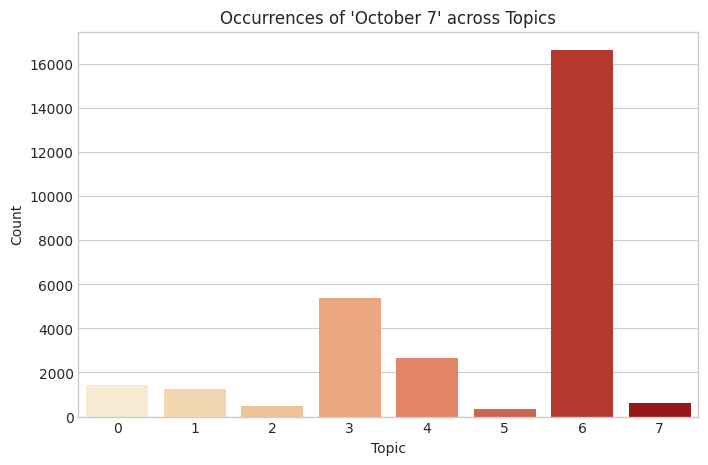

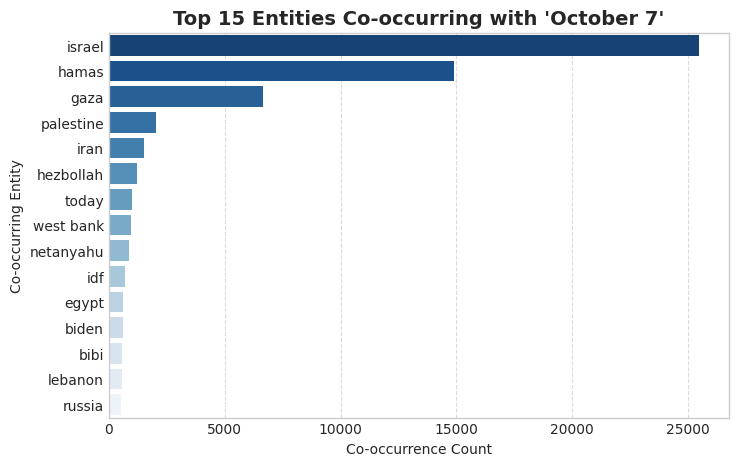

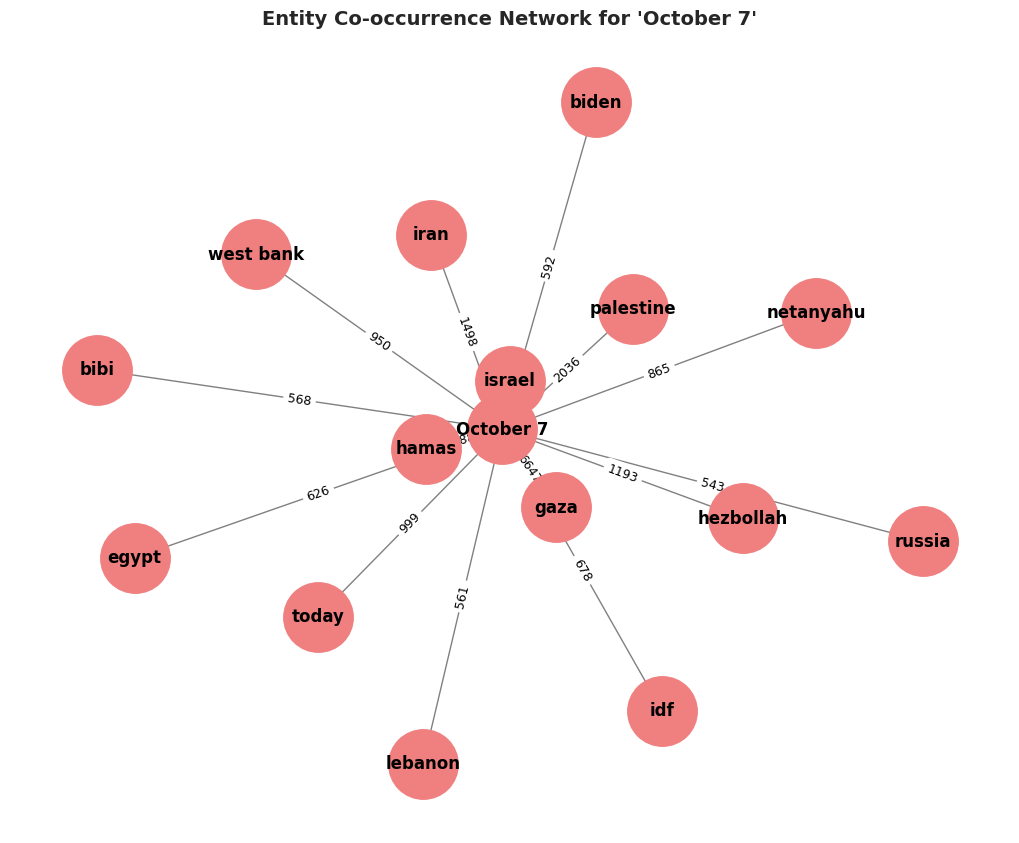

In [ ]:
# Standardize "October 7" mentions in a separate DataFrame
df_october7 = df_entities_with_id.copy()
october_variations = ["October", "Oct", "Oct 7", "October 7", "7th October", "Oct. 7", "October 7th"]
df_october7 = standardize_entity_names(df_october7, entity_variations=october_variations, standardized_name="October 7")

# Analyze occurrences of "October 7" across topics
df_october7_fixed = analyze_entity_mentions_substring(df_october7, entity_variations=["October 7"], entity_type_filter="DATE")

if df_october7_fixed is not None:
    print(df_october7_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_october7_fixed, entity_label="October 7")

# Compute and visualize co-occurring entities with "October 7"
df_october7_cooccurrence = compute_top_cooccurrence_for_target(df_october7, target_entity="October 7", top_n=15)
plot_cooccurrence_results(df_october7_cooccurrence, target_entity="October 7", top_n=15)
visualize_cooccurrence_network(df_october7_cooccurrence, target_entity="October 7")



Topic-Wise Distribution of 'October 7' Mentions The first graph illustrates how often 'October 7' appears across different topics. The findings indicate:
Topic 6 exhibits the highest frequency of 'October 7', significantly surpassing all other topics. Topics 3 and 4 also contain a relatively high number of mentions, suggesting their relevance to discussions around 'October 7'. Topics 0, 1, 2, 5, and 7 show substantially lower occurrences, indicating that these topics may be less directly associated with 'October 7'. This distribution suggests that discussions surrounding 'October 7' are concentrated in specific thematic clusters, likely related to geopolitical events, conflicts, and political discourse.

Co-Occurrence Analysis of 'October 7' with Other Entities The second visualization ranks the top 15 entities that frequently appear alongside 'October 7'. The dominant co-occurring entities include:
Israel (most frequent), followed by Hamas, Gaza, Palestine, Iran, Hezbollah, and IDF. Political figures and regions such as Netanyahu, Biden, Lebanon, and Russia are also present. The mention of 'Today' suggests a real-time or news-driven discussion component. This suggests that discussions involving 'October 7' are deeply interwoven with geopolitical themes, primarily centered on Israel and its regional adversaries, as well as broader international actors.



## Hamas

   Topic  Count
0      0  11448
1      1   2251
2      2   1284
3      3  26882
4      4  13597
5      5    362
6      6  49773
7      7    581


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




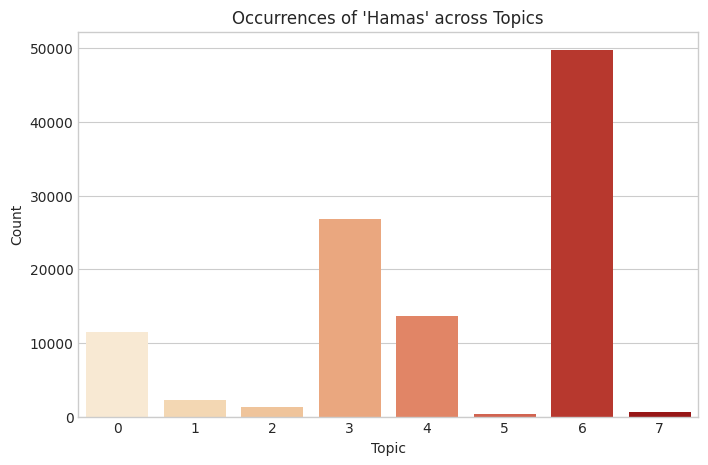

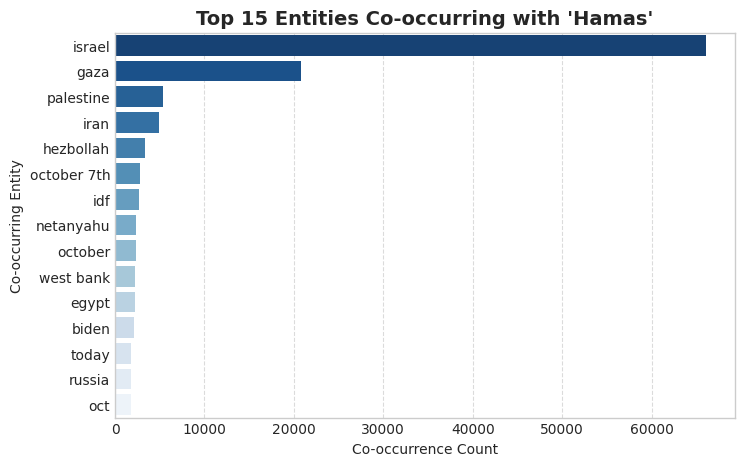

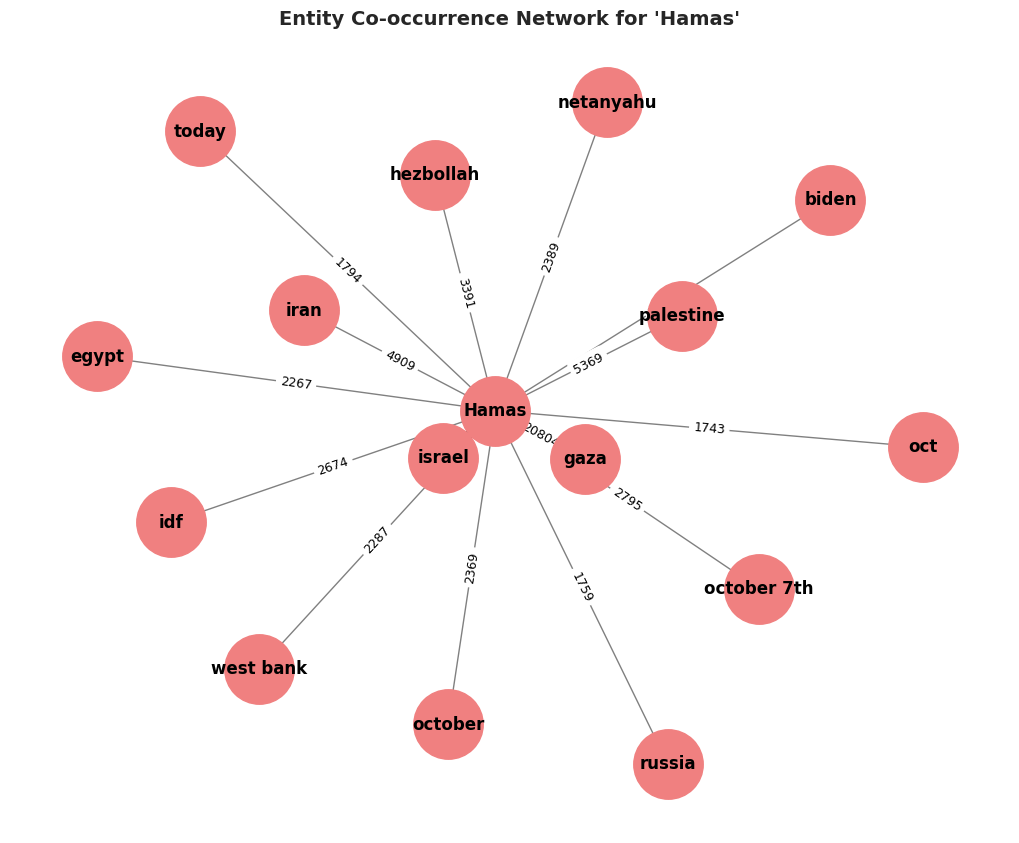

In [ ]:
# Standardize "Hamas" mentions in a separate DataFrame
df_hamas = df_entities_with_id.copy()
hamas_variations = ["Hamas", "hamas", "חמאס"]
df_hamas = standardize_entity_names(df_hamas, entity_variations=hamas_variations, standardized_name="Hamas")

# Analyze occurrences of "Hamas" across topics
df_hamas_fixed = analyze_entity_mentions_substring(df_hamas, entity_variations=["Hamas"], entity_type_filter="ORG")

# Only plot if data exists
if df_hamas_fixed is not None and not df_hamas_fixed.empty:
    print(df_hamas_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_hamas_fixed, entity_label="Hamas")
else:
    print("No topic-wise mentions found for 'Hamas'.")

# Compute and visualize co-occurring entities with "Hamas"
df_hamas_cooccurrence = compute_top_cooccurrence_for_target(df_hamas, target_entity="Hamas", top_n=15)
plot_cooccurrence_results(df_hamas_cooccurrence, target_entity="Hamas", top_n=15)
visualize_cooccurrence_network(df_hamas_cooccurrence, target_entity="Hamas")


The first graph illustrates the frequency of mentions of "Hamas" across different topics. The results indicate that the entity is most frequently discussed in Topic 6, followed by Topics 3 and 4. These trends suggest that discussions involving Hamas are predominantly concentrated in specific thematic areas, likely related to regional conflicts, security concerns, and political discourse.

Topic 6 dominates the discourse, with nearly 50,000 mentions of Hamas. This suggests that the discussions in this topic are highly focused on Hamas-related issues.
Topic 3 also shows significant mentions, which could indicate discussions related to geopolitical analysis or regional events.
Other topics have relatively lower mentions, showing that Hamas is not a primary entity in all conversations but rather in highly specific discussions.

The second graph highlights the top 15 entities that frequently co-occur with Hamas in posts and comments.

Israel is the most frequently co-occurring entity, reinforcing the central role of Hamas-Israel relations in discussions.
Gaza and Palestine also appear frequently, which aligns with the geographical and political context of Hamas.
Iran and Hezbollah are notable co-occurrences, reflecting discussions on alliances and external influences in Middle Eastern politics.
October 7 appears prominently, confirming that Hamas is widely discussed in relation to this event.
Other key figures, including Netanyahu and Biden, appear in the discussions, suggesting discourse about international responses and leadership decisions.



## Israel

   Topic   Count
0      0   28558
1      1   16270
2      2    2539
3      3   15511
4      4   86759
5      5    2318
6      6  139318
7      7   12762


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




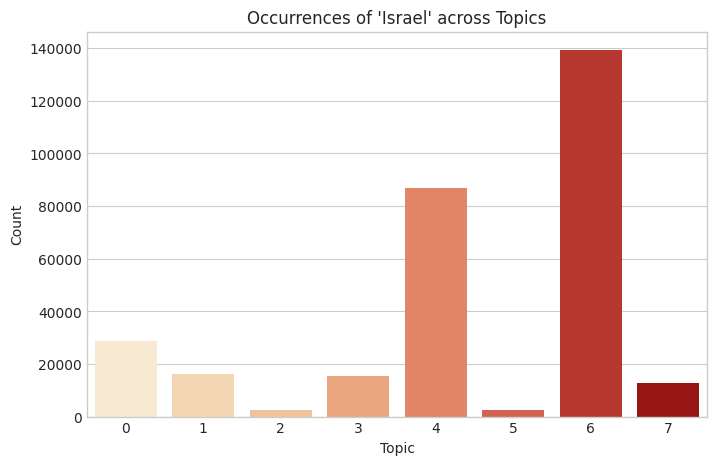

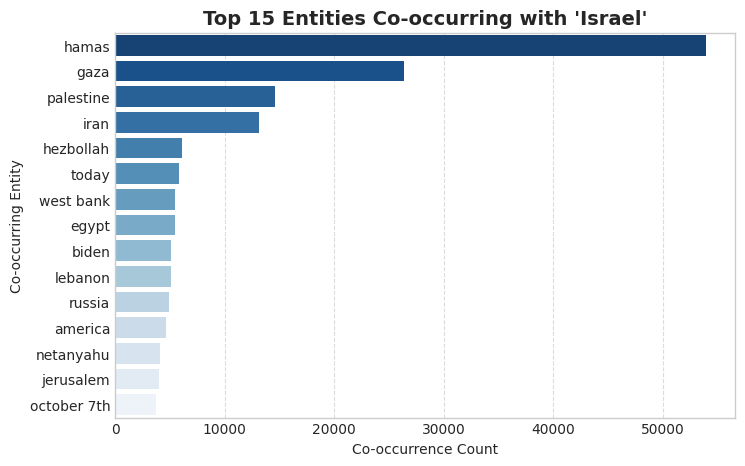

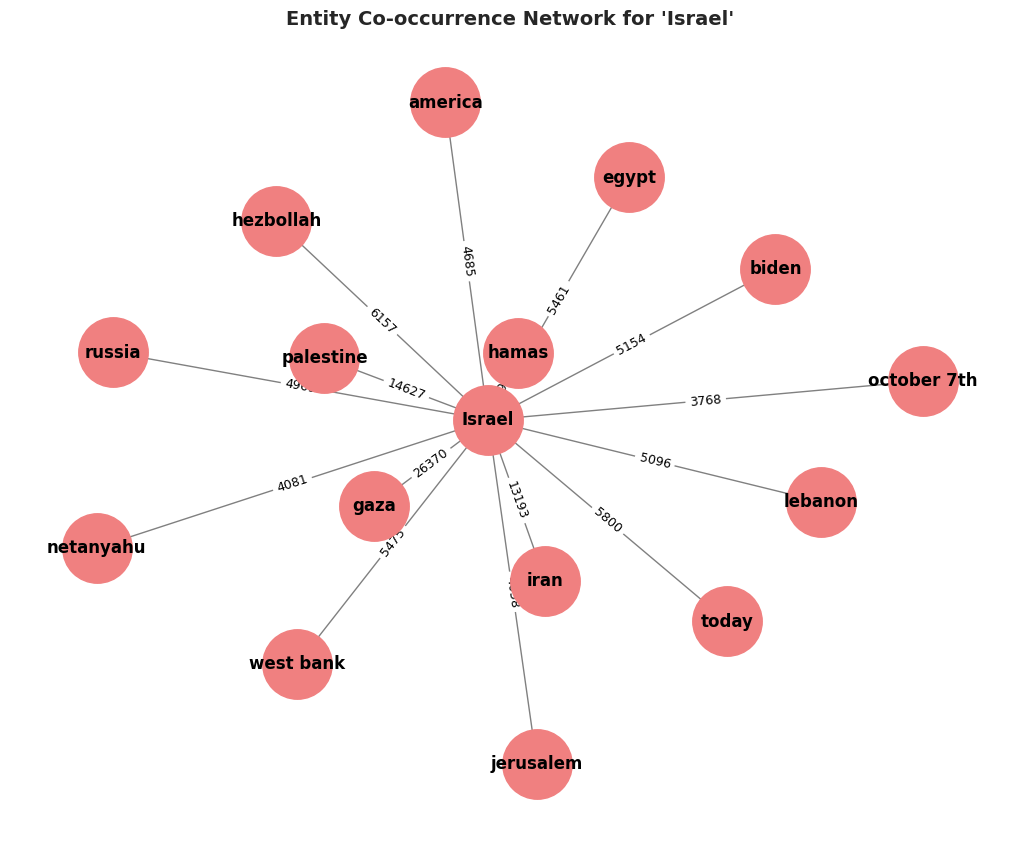

In [ ]:
# Standardize "Israel" mentions in a separate DataFrame
df_israel = df_entities_with_id.copy()
israel_variations = ["Israel", "israel", "ישראל"]
df_israel = standardize_entity_names(df_israel, entity_variations=israel_variations, standardized_name="Israel")

# Analyze occurrences of "Israel" across topics
df_israel_fixed = analyze_entity_mentions_substring(df_israel, entity_variations=["Israel"], entity_type_filter="GPE")

# Only plot if data exists
if df_israel_fixed is not None and not df_israel_fixed.empty:
    print(df_israel_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_israel_fixed, entity_label="Israel")
else:
    print("No topic-wise mentions found for 'Israel'.")

# Compute and visualize co-occurring entities with "Israel"
df_israel_cooccurrence = compute_top_cooccurrence_for_target(df_israel, target_entity="Israel", top_n=15)
plot_cooccurrence_results(df_israel_cooccurrence, target_entity="Israel", top_n=15)
visualize_cooccurrence_network(df_israel_cooccurrence, target_entity="Israel")




"Israel" is most frequently mentioned in topics 4 and 6, suggesting that discussions related to these topics prominently feature Israel.
There is also significant engagement in topic 3, while other topics have relatively lower mentions.
The peaks in topics 4 and 6 suggest that these categories encapsulate major geopolitical discussions, potentially concerning military conflicts, diplomacy, or political affairs.

The second visualization showcases the entities that appear most frequently alongside "Israel":

Hamas and Gaza are the top two entities co-occurring with "Israel," emphasizing the centrality of security and geopolitical discourse.
Palestine, Iran, and Hezbollah also feature prominently, reinforcing the idea that discussions involving "Israel" often include geopolitical adversaries and regional conflicts.
Other notable entities include the United States (America), Russia, and Egypt, suggesting broader international diplomatic and military discourse.
October 7 appears as a key co-occurring entity, likely linked to discussions about the Hamas attack on October 7, 2023, and its ramifications.

The entity co-occurrence network further confirms the dominant associations:

"Israel" is central to discussions involving Hamas, Gaza, Palestine, Iran, Hezbollah, and the West Bank, reinforcing the notion that Israel’s mentions are closely tied to regional security and political matters.
Benjamin Netanyahu (Netanyahu) is connected to Israel, as expected, given his role as a key political figure.
Biden and the United States (America) are linked, likely reflecting diplomatic ties and U.S. involvement in regional security.
October 7 appears prominently, indicating that discussions regarding this date are intertwined with Israel’s broader geopolitical narrative.


## Biden

   Topic  Count
0      0   4746
1      1    316
2      2    198
3      3    181
4      4    776
5      5     31
6      6   6427
7      7     73


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




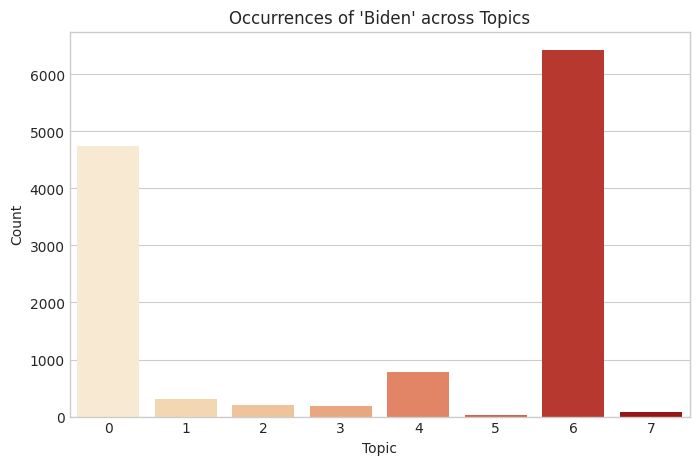

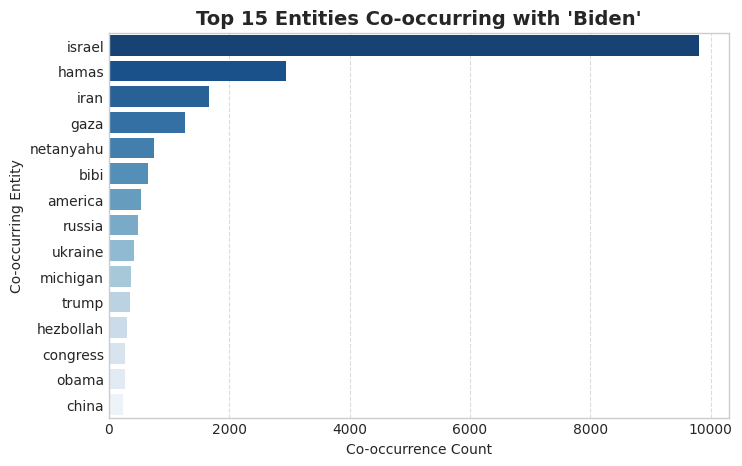

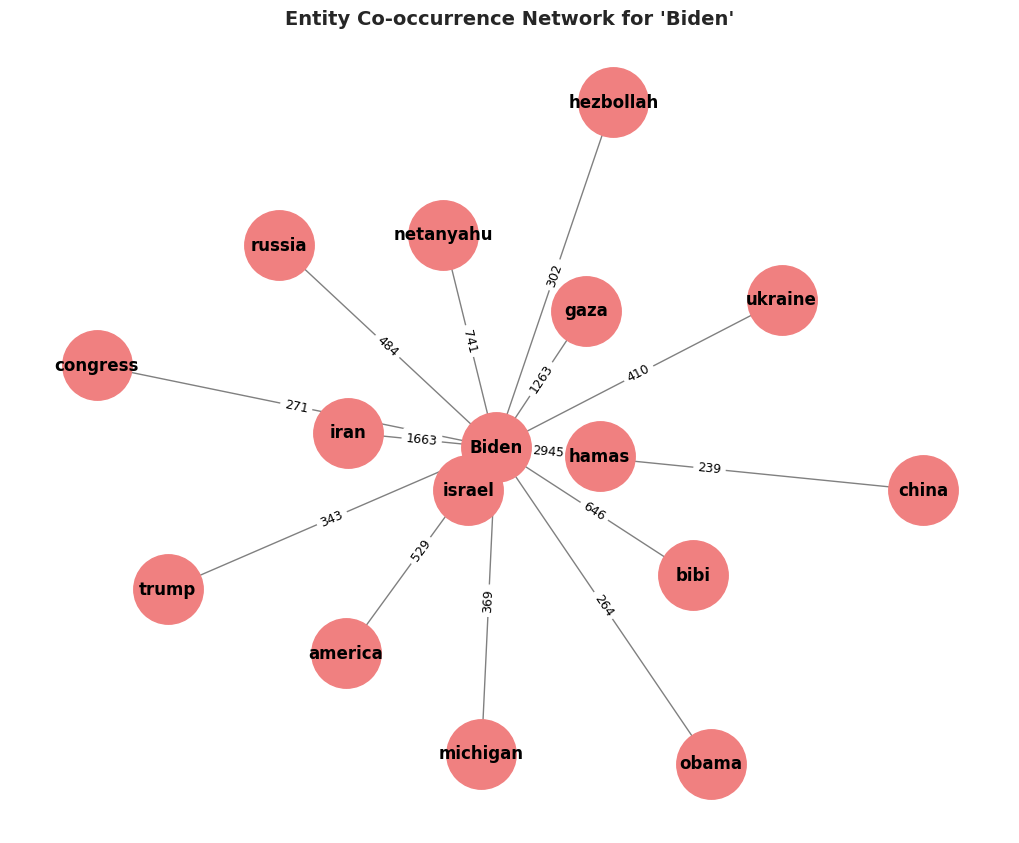

In [ ]:
# Standardize "Biden" mentions in a separate DataFrame
df_biden = df_entities_with_id.copy()
biden_variations = ["Biden", "Joe Biden", "President Biden"]
df_biden = standardize_entity_names(df_biden, entity_variations=biden_variations, standardized_name="Biden")

# Analyze occurrences of "Biden" across topics
df_biden_fixed = analyze_entity_mentions_substring(df_biden, entity_variations=["Biden"], entity_type_filter="PERSON")

# Only plot if data exists
if df_biden_fixed is not None and not df_biden_fixed.empty:
    print(df_biden_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_biden_fixed, entity_label="Biden")
else:
    print("No topic-wise mentions found for 'Biden'.")

# Compute and visualize co-occurring entities with "Biden"
df_biden_cooccurrence = compute_top_cooccurrence_for_target(df_biden, target_entity="Biden", top_n=15)
plot_cooccurrence_results(df_biden_cooccurrence, target_entity="Biden", top_n=15)
visualize_cooccurrence_network(df_biden_cooccurrence, target_entity="Biden")



The name "Biden" appears most frequently in Topic 6, indicating a strong association with discussions related to this theme.
A significant number of mentions also appear in Topic 0, though at a lower frequency.
Mentions in other topics are notably lower, suggesting that the discussion around Biden is concentrated within specific narratives.

The most frequently co-occurring entity with "Biden" is "Israel," indicating that discussions involving Biden often relate to the country, potentially in a geopolitical or diplomatic context.
"Hamas," "Iran," and "Gaza" also feature prominently, suggesting a linkage between Biden and discussions regarding Middle Eastern conflicts, security issues, or foreign policy.
"Netanyahu" and "Bibi" appear as key co-occurring entities, reinforcing the idea that Biden's interactions with Israeli leadership are a focal point.
Other geopolitical entities like "Russia," "Ukraine," "China," and "America" also appear frequently, indicating that Biden is discussed in the context of global politics.
Terms like "Trump," "Congress," and "Obama" suggest that Biden is mentioned within a broader political discourse, potentially comparing his policies or leadership to previous administrations.

The network visualization shows Biden at the center, with strong links to Israel, Hamas, Iran, and Netanyahu.
The presence of entities like "China" and "Ukraine" suggests that discussions also touch on global conflicts or international relations beyond the Middle East.
The relatively strong linkage to "Trump" and "Obama" implies that Biden’s policies or actions are often discussed in contrast with former U.S. presidents.

## Bibi

   Topic  Count
0      0   4649
1      1    411
2      2    107
3      3    546
4      4   1909
5      5     82
6      6   9425
7      7    165


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




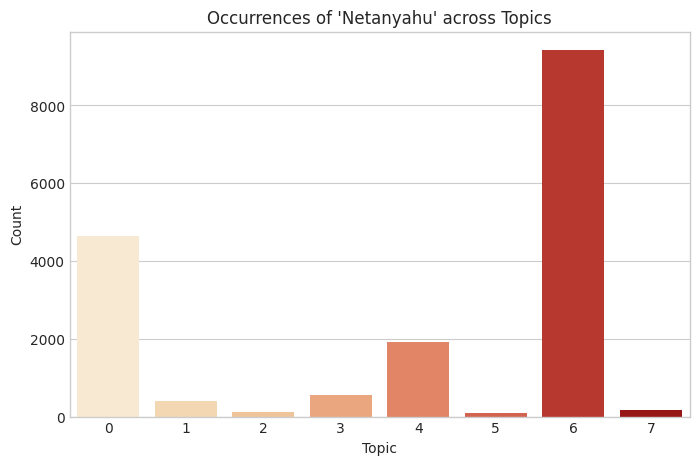

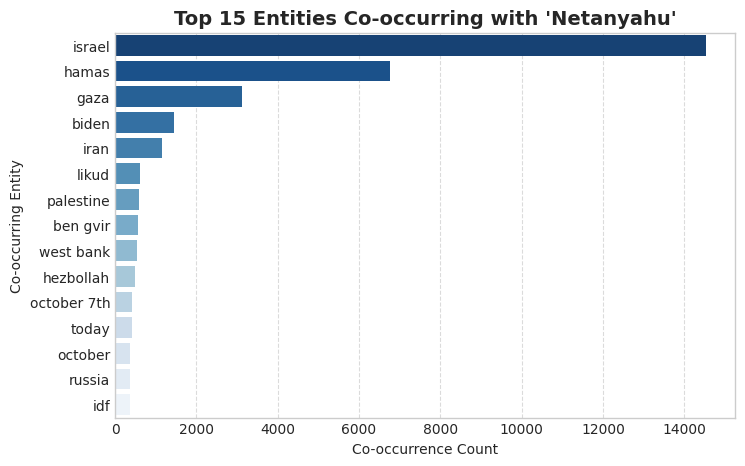

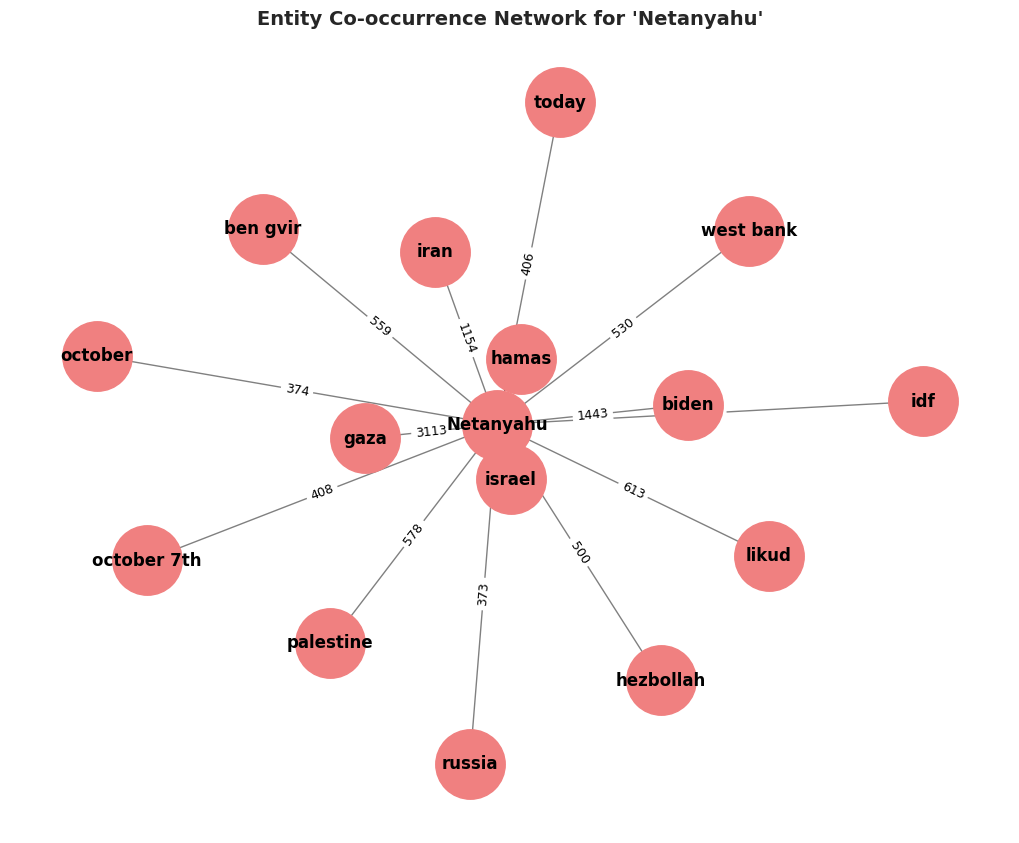

In [ ]:
# Standardize "Bibi / Netanyahu" mentions in a separate DataFrame
df_netanyahu = df_entities_with_id.copy()
netanyahu_variations = ["Bibi", "Netanyahu", "Benjamin Netanyahu", "Prime Minister Netanyahu"]
df_netanyahu = standardize_entity_names(df_netanyahu, entity_variations=netanyahu_variations, standardized_name="Netanyahu")

# Analyze occurrences of "Netanyahu" across topics
df_netanyahu_fixed = analyze_entity_mentions_substring(df_netanyahu, entity_variations=["Netanyahu"], entity_type_filter="PERSON")

# Only plot if data exists
if df_netanyahu_fixed is not None and not df_netanyahu_fixed.empty:
    print(df_netanyahu_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_netanyahu_fixed, entity_label="Netanyahu")
else:
    print("No topic-wise mentions found for 'Netanyahu'.")

# Compute and visualize co-occurring entities with "Netanyahu"
df_netanyahu_cooccurrence = compute_top_cooccurrence_for_target(df_netanyahu, target_entity="Netanyahu", top_n=15)
plot_cooccurrence_results(df_netanyahu_cooccurrence, target_entity="Netanyahu", top_n=15)
visualize_cooccurrence_network(df_netanyahu_cooccurrence, target_entity="Netanyahu")


Dominant Topics: Netanyahu is primarily mentioned in topic 6, suggesting a strong connection to political and military discourse.
Co-Occurring Entities: The most frequent co-occurrences include Israel, Hamas, Gaza, and Biden, indicating that his leadership is often discussed in the context of conflict and diplomacy.
Additional Entities: Mentions of Ben Gvir, Likud, Hezbollah, and October 7 suggest that Netanyahu’s discussions are closely tied to internal Israeli politics and external security threats.

## WW2

   Topic  Count
0      0     21
1      1     20
2      2     16
3      3     24
4      4    187
5      5      8
6      6    308
7      7     92


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




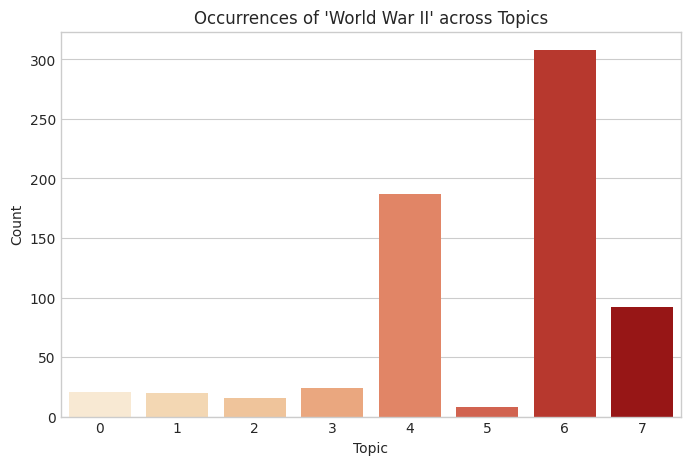

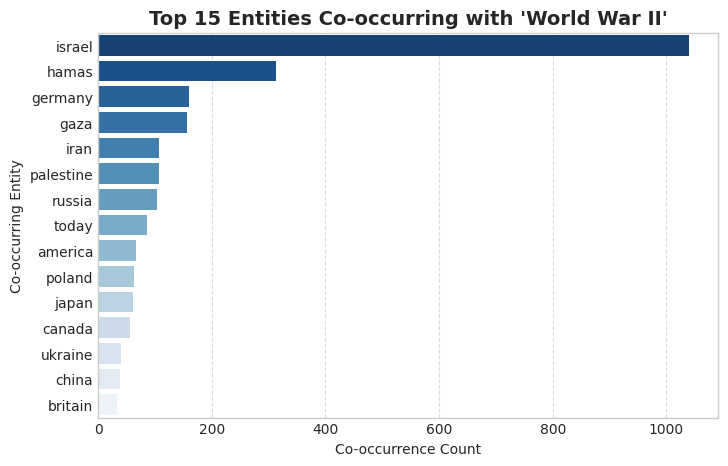

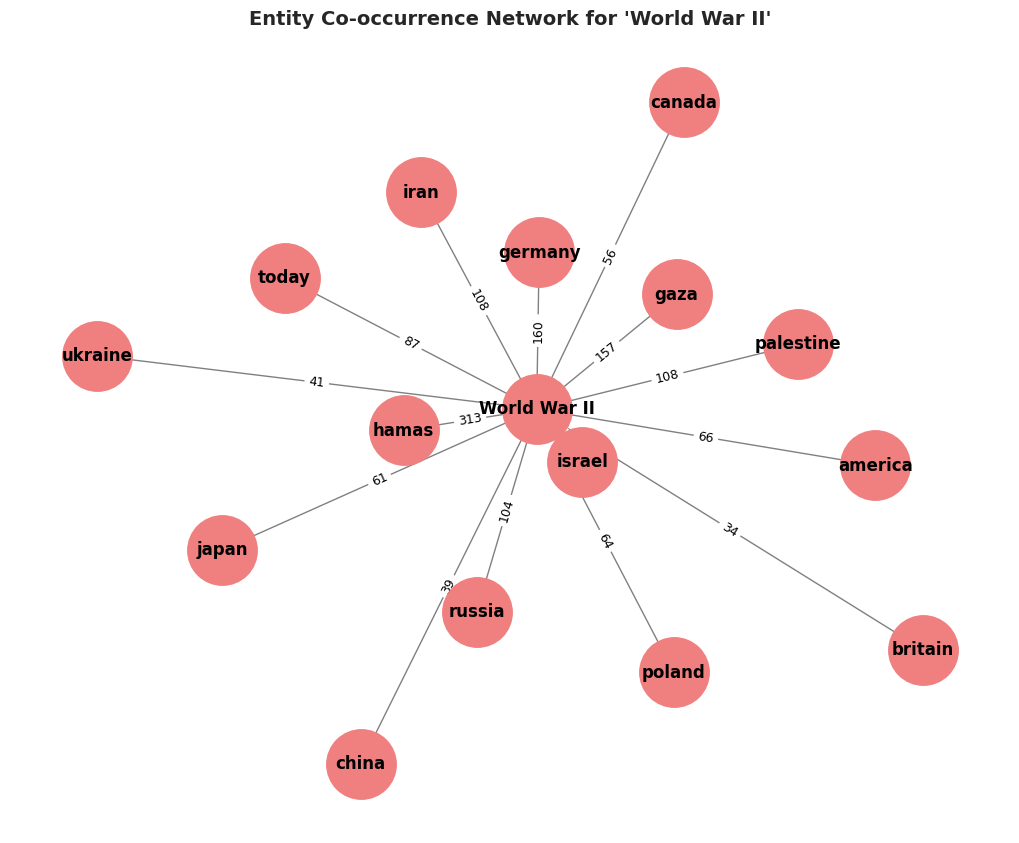

In [ ]:
# Standardize "World War II" mentions in a separate DataFrame
df_ww2 = df_entities_with_id.copy()
ww2_variations = ["World War II", "WWII", "Second World War", "WW2"]
df_ww2 = standardize_entity_names(df_ww2, entity_variations=ww2_variations, standardized_name="World War II")
# Analyze occurrences of "World War II" across topics
df_ww2_fixed = analyze_entity_mentions_substring(df_ww2, entity_variations=["World War II"], entity_type_filter="EVENT")

# Only plot if data exists
if df_ww2_fixed is not None and not df_ww2_fixed.empty:
    print(df_ww2_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_ww2_fixed, entity_label="World War II")
else:
    print("No topic-wise mentions found for 'World War II'.")
# Compute and visualize co-occurring entities with "World War II"
df_ww2_cooccurrence = compute_top_cooccurrence_for_target(df_ww2, target_entity="World War II", top_n=15)
plot_cooccurrence_results(df_ww2_cooccurrence, target_entity="World War II", top_n=15)
visualize_cooccurrence_network(df_ww2_cooccurrence, target_entity="World War II")


The first graph highlights the frequency of "World War II" mentions across different topics. Key findings include:

The most significant mentions occur in Topic 6, which suggests a concentrated discourse around this subject.
Topic 4 also exhibits a notable number of occurrences, indicating a secondary cluster of discussions where "World War II" is a recurring theme.
Other topics contain minimal mentions, showing that discussions about the war are largely confined to a limited set of discussions.

The bar chart illustrating the most common entities appearing alongside "World War II" provides insight into how this historical event is contextualized:

Israel appears as the most frequently co-occurring entity, reflecting its historical connection to World War II, particularly in the context of the Holocaust and its impact on the formation of the state.
Hamas and Gaza show up prominently, suggesting that contemporary political and military conflicts are often discussed in relation to past global conflicts.
Germany and Iran rank highly, likely in reference to Germany’s role in World War II and Iran’s geopolitical positioning in modern narratives involving global conflicts.
Other countries such as Russia, Poland, China, Japan, Canada, Ukraine, and Britain are frequently mentioned, which aligns with their involvement in the war and its long-term geopolitical consequences.
America and Today suggest that discussions may draw historical parallels between World War II and contemporary global events.

The network visualization highlights the strongest relationships between "World War II" and other entities:

The strongest connection is with Israel, reinforcing how discussions of World War II often involve themes related to Jewish history, the Holocaust, and the subsequent establishment of the state of Israel.
Hamas, Gaza, and Palestine indicate that historical comparisons may be drawn between past wars and present-day conflicts in the Middle East.
Germany, Russia, and Britain are prominent nodes, reflecting their historical significance in World War II.
Mentions of China, Japan, and Poland suggest broader discussions encompassing different theaters of the war.
The presence of today, Canada, and Iran in the network indicates that modern political discourse frequently references World War II, possibly in discussions of international relations, conflict, and diplomacy.

## Holocaust

   Topic  Count
0      0      3
1      1      1
2      2      1
3      3      1
4      4      8
5      5      2
6      6      8
7      7      2


/tmp/ipykernel_356476/366692908.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




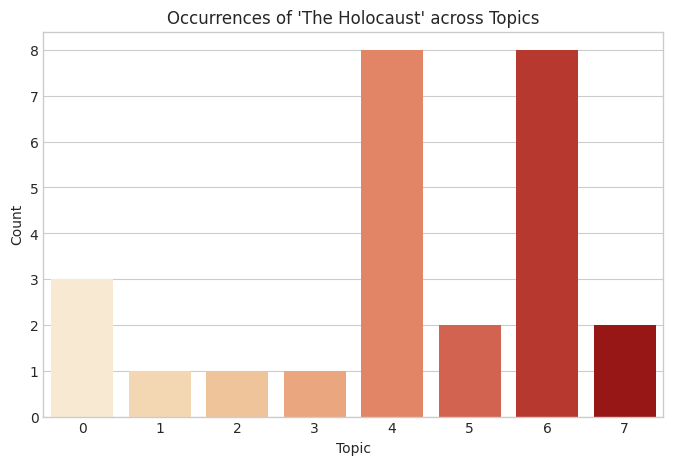

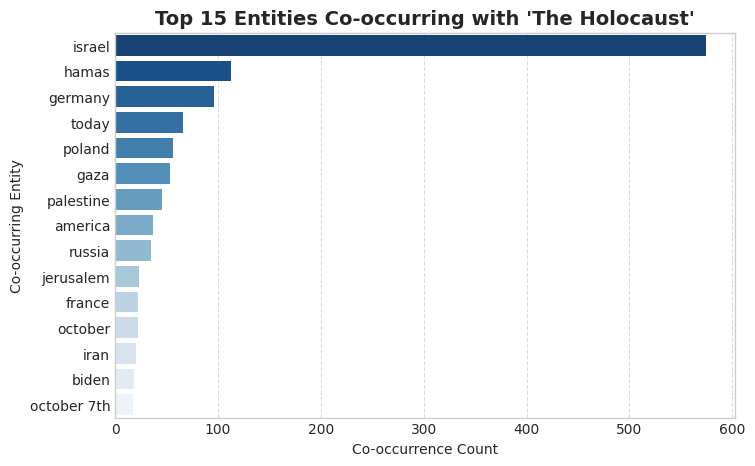

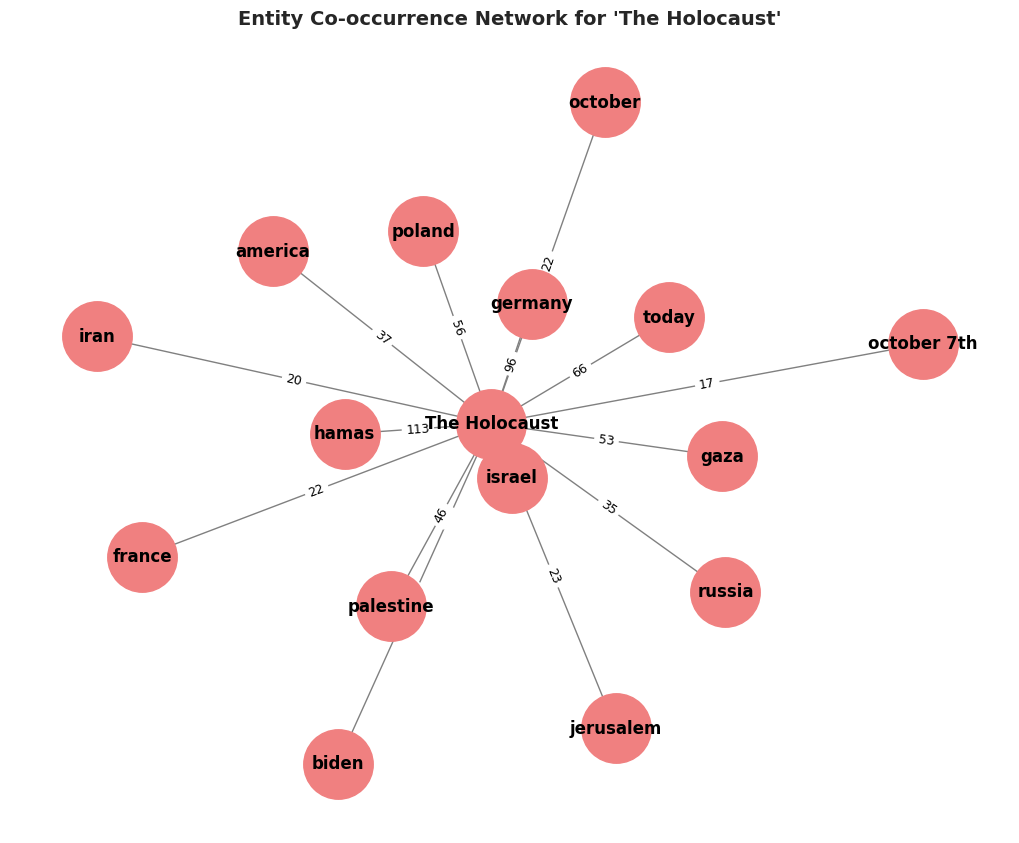

In [ ]:
# Standardize "The Holocaust" mentions in a separate DataFrame
df_holocaust = df_entities_with_id.copy()
holocaust_variations = ["The Holocaust", "Holocaust", "Shoah"]
df_holocaust = standardize_entity_names(df_holocaust, entity_variations=holocaust_variations, standardized_name="The Holocaust")
# Analyze occurrences of "The Holocaust" across topics
df_holocaust_fixed = analyze_entity_mentions_substring(df_holocaust, entity_variations=["The Holocaust"], entity_type_filter="EVENT")

# Only plot if data exists
if df_holocaust_fixed is not None and not df_holocaust_fixed.empty:
    print(df_holocaust_fixed)  # Display topic-wise occurrences
    plot_entity_mentions(df_holocaust_fixed, entity_label="The Holocaust")
else:
    print("No topic-wise mentions found for 'The Holocaust'.")
# Compute and visualize co-occurring entities with "The Holocaust"
df_holocaust_cooccurrence = compute_top_cooccurrence_for_target(df_holocaust, target_entity="The Holocaust", top_n=15)
plot_cooccurrence_results(df_holocaust_cooccurrence, target_entity="The Holocaust", top_n=15)
visualize_cooccurrence_network(df_holocaust_cooccurrence, target_entity="The Holocaust")

Topic Distribution: The Holocaust appears in Topics 4 and 6, highlighting discussions related to historical narratives and possibly contemporary antisemitism.
Top Co-occurring Entities: The Holocaust is strongly linked with Israel, Hamas, Germany, Poland, and Gaza, suggesting that discussions may involve historical and contemporary implications of antisemitism, the Israeli-Palestinian conflict, and Jewish history.
Network Analysis: The graph includes mentions of October 7, France, and Jerusalem, indicating that historical comparisons and remembrance may play a role in these discussions.